# Building New Data Driven Wavelength Solution and Spectrum Normalization for NIR


To build a new wavelength solution we're going to assume we have some poorly registered NIRDA images of bright hot stars.

We need to find

- Pixel x position of the trace
- Wavelength position of the trace
- Normalization of the trace to convert between e$^-$ and physical units.

To do this we'll generate some fake data

In [1]:
import lamatrix
import pandorapsf as pp
import pandorasat as ps
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import pandas as pd
from tqdm import tqdm

nirda = ps.NIRDetector()
p = pp.PSF.from_name("nirda_fallback", transpose=True)
ts = pp.TraceScene(np.asarray([[300, 40]]), psf=p, wavelength=p.trace_wavelength[:-1])

To calibrate the wavelength solution we're going to use lots of **hot** stars which should have a lot of hydrogen lines in the IR. 

## Generating Fake Data Set

First we'll create some fake data we're going to create

- 30 stars
- 6500K to 8000K
- jmag 7 - 8
- Some position changes during integration
- Poorly known image registration
- Reasonable detector noise


Below I make some fake data

Some assumptions here: 

- There are no other high level calibration products (e.g. pointing calibration). We may have calibrations such as flats and bad pixel maps to improve our data, and we should be able to have data in units of electrons
- We are in a photon noise dominated realm, meaning we can assume the errors on the data are just the square root.

In [2]:
nsources = 30
mags = -np.abs(np.random.normal(0, 0.5, size=nsources)) + 8
teffs = np.random.uniform(6500, 8000, size=nsources)

# Each target has a different position because we assume we don't have good calibration yet
# Each target drifts during an exposure, as we think we may not have the pointing dialed in
delta_poss = np.random.normal(0, 5, size=(nsources, 2, 1)) + np.random.normal(0, 1, size=(nsources, 2, 250))

In [3]:
datasets = []
for teff, mag, delta_pos in tqdm(zip(teffs, mags, delta_poss), total=len(teffs), leave=True, position=0):
    wav, sed = ps.phoenix.get_phoenix_model(teff, jmag=mag)
    k = (wav.to(u.micron).value > 0.9) & (wav.to(u.micron).value < 2)
    flux = ts.integrate_spectrum(wav, sed)

    ar = (ts.model(flux[:, None, None] * np.ones((1, 1, 250)), delta_pos=delta_pos, quiet=True) * nirda.frame_time()).to(u.electron/u.pix)
    ar = ar.reshape((10, 25, 400, 80)).mean(axis=0)
    ar[0] *= 0
    data = np.cumsum(ar.value, axis=0)
    data[data > 0] = np.random.poisson(data[data > 0])
    # Read Noise
    data += np.random.normal(
        loc=0,
        scale=nirda.readnoise.value,
        size=data.shape,
    ).astype(int)
    
    # Add poisson noise for the dark current to every frame, units of electrons
    data += np.random.poisson(
        lam=(nirda.dark * nirda.frame_time().to(u.second)).value,
        size=data.shape,
    ).astype(int)
    datasets.append(data)
datasets = np.asarray(datasets)

100%|███████████████████████████████████████████| 30/30 [02:27<00:00,  4.90s/it]


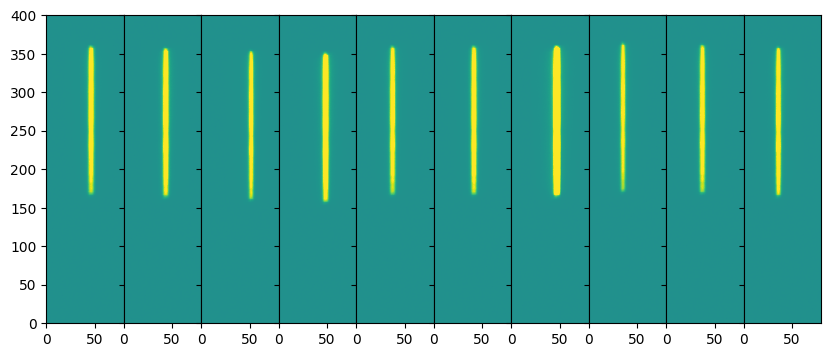

In [4]:
fig, ax = plt.subplots(1, 10, sharex=True, sharey=True, figsize=(10, 4))
for idx in range(np.min([len(datasets), 10])):
    ax[idx].pcolormesh(datasets[idx][-1], vmin=-5000, vmax=5000)
plt.subplots_adjust(wspace=0)

## Aligning Spectra

The first step is to take each dataset and find the edges. 

Because we think the instrument may be poorly registered and our guidance may not be good, we're going to work at the frame level. We've chosen bright stars so we should have enough signal to noise in a short time span.

Here are some gotchas:

- The native frame rate is 0.32s. We're going to bin up by 6 frames to increase the signal to noise. You might need to tune this number to get the right signal to noise.
- Remember we're assuming basic corrections (e.g. bias removal, flat, gain) have been applied in this dataset.
- I'm assuming the units of each grame group are `electrons`. You may have it in `DN` depending on if you've applied the gain correction. Make sure you track units carefully.
- You may need to tune parameters in the code below to get this to work properly, depending on where the spectra are landing on the detector.

We'll make a dataset of all of the spectra and the pixels that were read out. We'll calculate where the edges of the spectra are and then align them.

In [5]:
pix = np.arange(datasets.shape[2])

In [6]:
dfs = []
bin_frames = 6
le, re = [], []
for idx in np.arange(0, len(datasets)):
    frames = np.diff(datasets[idx], axis=0)
    frames = frames.reshape((24//bin_frames, bin_frames, *frames.shape[1:])).sum(axis=1)
    # aper = (frames > 200).any(axis=0)
    aper = (frames.sum(axis=2) > 200).any(axis=0)[:, None] * (frames.sum(axis=1) > 2000).any(axis=0)[None, :]
    for count in range(10):
        aper |= (np.asarray(np.gradient(aper.astype(float))) != 0).any(axis=0)
    spectra = (frames * aper).sum(axis=2)
    left_edge, right_edge = np.zeros((2, spectra.shape[0]))

    for jdx, spectrum in enumerate(spectra):
        k = (pix > 125) & (pix < 200)
        grad = np.gradient(spectrum[k], pix[k])
        l = np.argmax(grad)
        a, b, c = np.polyfit(pix[k][l-1:l+2], np.log(np.abs(grad[l-1:l+2])), 2)
        sigma = np.sqrt(-1/(2*a))
        left_edge[jdx] = b * sigma**2
        k = (pix > 325) & (pix < 375)
        grad = np.gradient(spectrum[k], pix[k])
        l = np.argmin(grad)
        a, b, c = np.polyfit(pix[k][l-1:l+2], np.log(np.abs(grad[l-1:l+2])), 2)
        sigma = np.sqrt(-1/(2*a))
        right_edge[jdx] = b * sigma**2
    centers = np.mean([left_edge, right_edge], axis=0)
    df = pd.DataFrame(np.vstack([(np.ones(spectra.shape) * idx).ravel(),
                                 (np.ones((1, pix.shape[0])) *  np.arange(spectra.shape[0])[:, None]).ravel(),
                                 (pix * np.ones((len(centers), 1))).ravel(),
                                 (pix - centers[:, None]).ravel(),
                                 (np.ones(spectra.shape)).ravel() * (10**((mags[idx] - 8)/-2.5)), 
                                 (np.ones(spectra.shape)).ravel() * mags[idx], 
                                 (np.ones(spectra.shape)).ravel() * teffs[idx], 
                                 spectra.ravel()]).T, columns=["target", "frame", "x0", "x", "norm", "mag", "teff", "y"])
    le.append(left_edge - centers)
    re.append(right_edge - centers)
    dfs.append(df)
df = pd.concat(dfs)
le = np.mean(le)
re = np.mean(re)

Below we have the extracted data for each target (shown in color) as a function of pixel.

In [7]:
df.head()

,target,frame,x0,x,norm,mag,teff,y
0,0.0,0.0,0.0,-262.479085,1.222198,7.782146,6954.073109,41.0
1,0.0,0.0,1.0,-261.479085,1.222198,7.782146,6954.073109,-86.0
2,0.0,0.0,2.0,-260.479085,1.222198,7.782146,6954.073109,-93.0
3,0.0,0.0,3.0,-259.479085,1.222198,7.782146,6954.073109,59.0
4,0.0,0.0,4.0,-258.479085,1.222198,7.782146,6954.073109,75.0


[Text(0.5, 0, 'Pixel Position'), Text(0, 0.5, 'Signal [$e^-/pixel$]')]

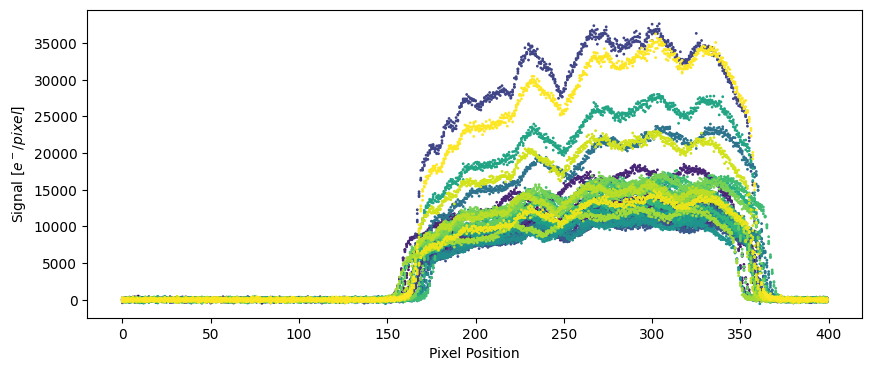

In [8]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(df.x0, df.y, c=df.target, s=1)
ax.set(xlabel='Pixel Position', ylabel='Signal [$e^-/pixel$]')

Below is the same data, aligned using the edges of the spectra and normalized using j mag. I have colored them by their effective temperature.

[Text(0.5, 0, 'Pixel Position - Trace Center'),
 Text(0, 0.5, 'Signal [$e^-/pixel$]')]

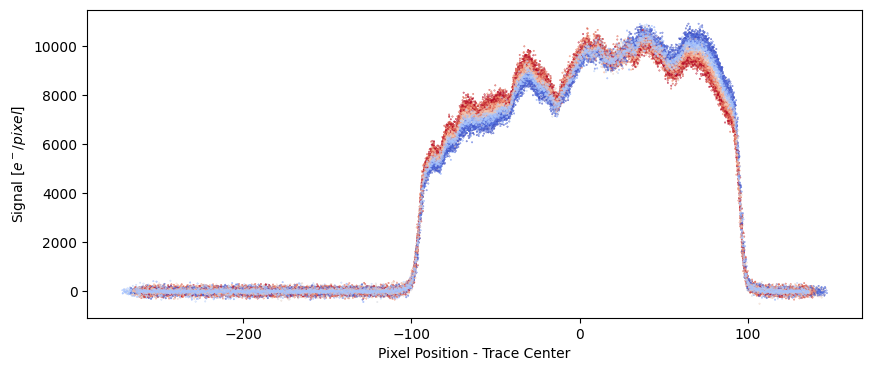

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(df.x, df.y/df.norm, c=df.teff, s=0.1, cmap='coolwarm')
ax.set(xlabel='Pixel Position - Trace Center', ylabel='Signal [$e^-/pixel$]')

Now we need to take the average of the spectra. We'll do this with a spline model so we can get the smooth, average trend through the points.

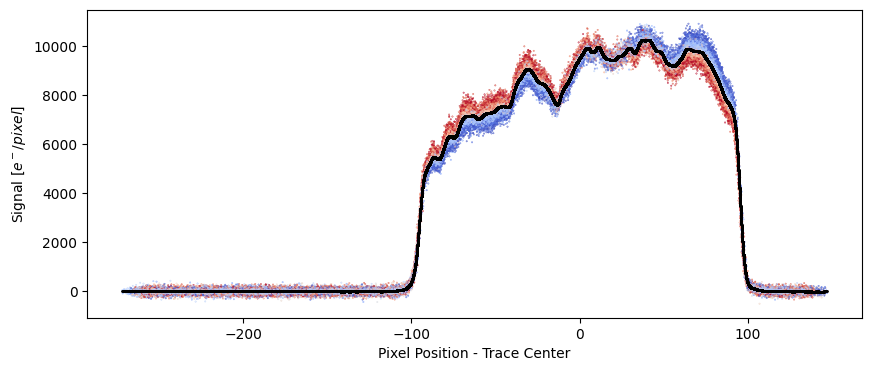

In [10]:
from lamatrix import Spline
s = Spline("x", knots=np.arange(-150, 150, 2))
s.fit(x=df.x.values, data=df.y.values/df.norm.values)
df['model'] = s.evaluate(x=df.x.values)
df['gradgrad'] = np.gradient(np.gradient(df.model.values/df.y.values.mean(), df.x), df.x)


fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(df.x, df.y/df.norm, c=df.teff, s=0.1, cmap='coolwarm')
ax.set(xlabel='Pixel Position - Trace Center', ylabel='Signal [$e^-/pixel$]')

plt.scatter(df.x.values, df.model.values, c='k', s=1)

# plt.plot(df.x, 5*df['gradgrad'])
plt.show()

Just to do a sanity check here, let's sum up all the flux in the image and show that it correlates with the expected J band magnitude. This should be strongly, tightly correlated.

If you're doing this on real data, you might want to use an aperture.

In [11]:
total_flux = np.zeros(len(teffs))
for tdx in range(len(teffs)):
    k = df.target == tdx
    total_flux[tdx] = np.trapz(df[k].y.values * u.electron/u.pixel, df[k].x.values*u.pixel).to(u.electron).value

[Text(0.5, 0, 'J Magnitude'), Text(0, 0.5, 'Total Flux [$e^-$]')]

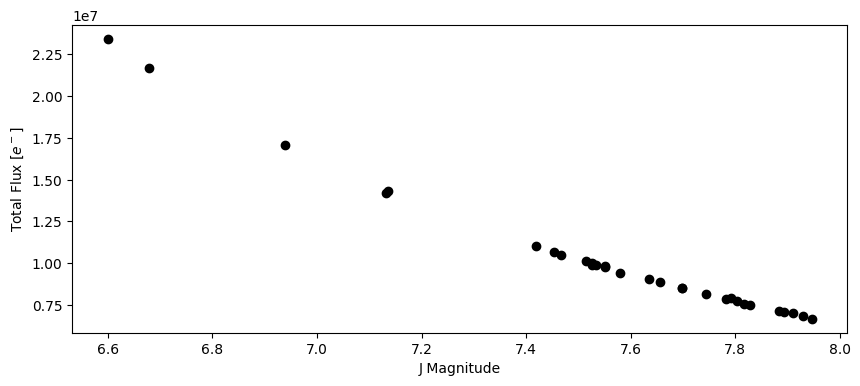

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(mags, total_flux, c='k')
ax.set(xlabel='J Magnitude', ylabel='Total Flux [$e^-$]')

## Building Wavelength Calibration

Now we have the average spectrum, we need to calculate the wavelength calibration. You can use the region picker widget below to pull out the pixel values of the hydrogen lines.

The plot below will help you identify the hydrogen lines in the spectrum. This is the expectation of where the lines will fall given pre-launch estimates of all Pandora parameters. You should search for these features in the region picker.

In [13]:
paschen = np.sort([1.28216, 1.09411, 1.00521, 0.95486, 0.92315, 0.90174])

In [14]:
ts.X.reset(), ts.dX0.reset(), ts.dX1.reset()

(None, None, None)

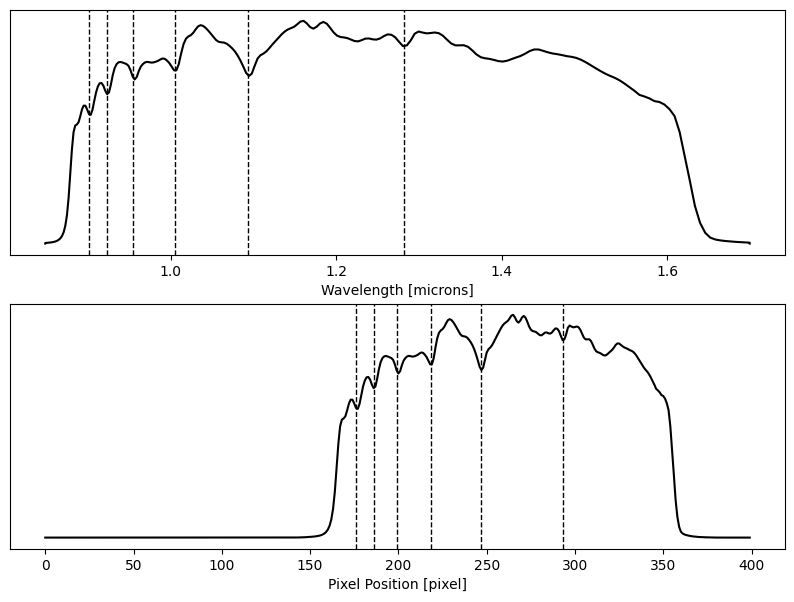

In [15]:
wav, sed = ps.phoenix.get_phoenix_model(9500, jmag=9)
# flux = (ts.integrate_spectrum(wav, sed)).value
spec = ts.model(sed, wavelength=wav)[0].sum(axis=1)# * nirda.frame_time(nirda.subarray_size)).value

fig, ax = plt.subplots(2, 1, figsize=(10, 7))
pix = np.arange(0, 400)
k = (wav.to(u.micron) > 0.8*u.micron) & (wav.to(u.micron) < 1.8*u.micron)
# ax[0].plot(wav[k].to(u.micron), sed[k]/sed[k].mean(), c='k')
ax[0].plot(np.interp(np.arange(0, 400) - 300 + 1, ts.pixel.value, ts.wavelength.value), spec/spec.mean(), c='k')
ax[1].plot(pix, spec/spec.mean(), c='k')
[ax[0].axvline(p, c='k', ls='--', lw=1) for p in paschen]
[ax[1].axvline(nirda.reference.get_pixel_position(p).value + 300 - 1, c='k', ls='--', lw=1) for p in paschen]

ax[0].set(xlabel='Wavelength [microns]', ylabel='', yticks=[])
ax[1].set(xlabel='Pixel Position [pixel]', ylabel='', yticks=[]);

In [16]:
%matplotlib widget

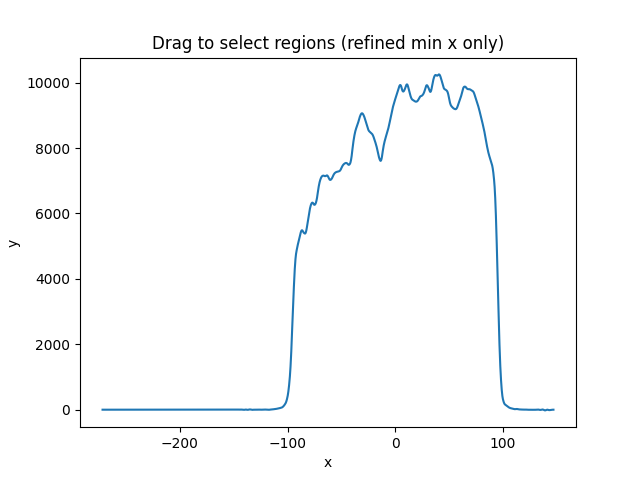

In [17]:
from regionpicker import RegionPicker
s = np.argsort(df.x.values)
rp = RegionPicker(df.x.values[s], df.model.values[s], window_pts=31)
display(rp.widget())

In [18]:
%matplotlib inline

In [19]:
paschen_pix = np.sort([-84.208,-75.0545,-60.4599,-43.3508,-13.7212,32.5214])
wav_poly = l = np.polyfit(paschen_pix, paschen, 2)

df['wavelength'] = np.polyval(l, df.x.values)

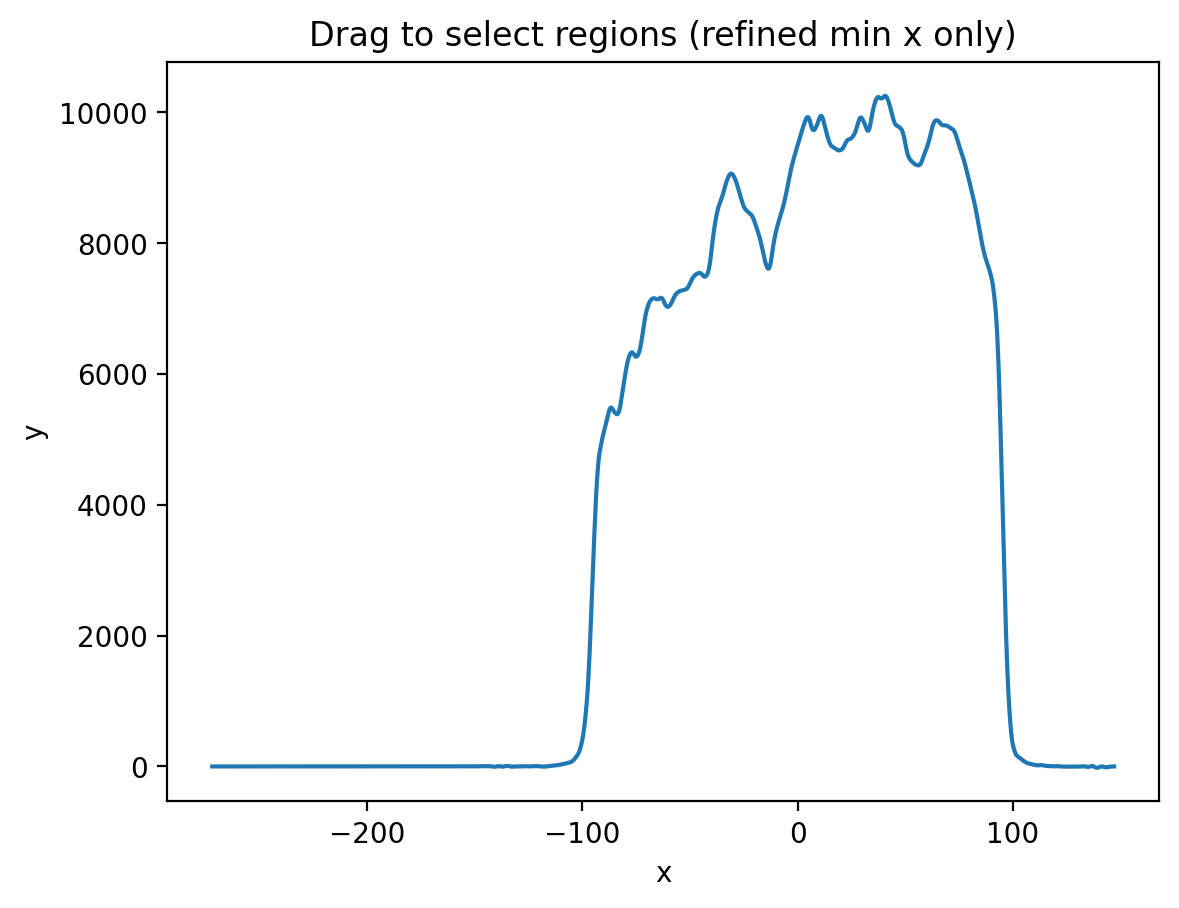

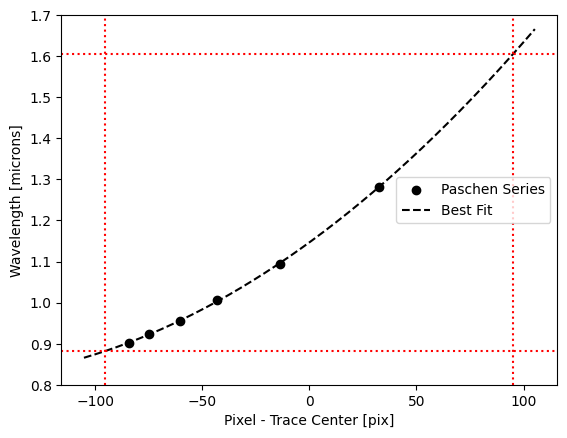

In [20]:
fig, ax = plt.subplots()
plt.scatter(paschen_pix, paschen, c='k', label='Paschen Series')
plt.plot(np.linspace(le-10, re+10, 1000), np.polyval(l, np.linspace(le-10, re+10, 1000)), c='k', label='Best Fit', ls='--')
ax.legend()
ax.axvline(le, c='r', ls=':')
ax.axvline(re, c='r', ls=':')
ax.axhline(np.polyval(l, le), c='r', ls=':')
ax.axhline(np.polyval(l, re), c='r', ls=':')
ax.set(xlabel='Pixel - Trace Center [pix]', ylabel='Wavelength [microns]', ylim=(0.8, 1.7))
plt.show();


Below we show the input truth and compare with our extracted wavelength solution. 

The extracted trace edges are shown in red. The extracted Paschen lines are shown in orange. The true paschen lines are shown in lime. The true input sensitivity is shown in black.

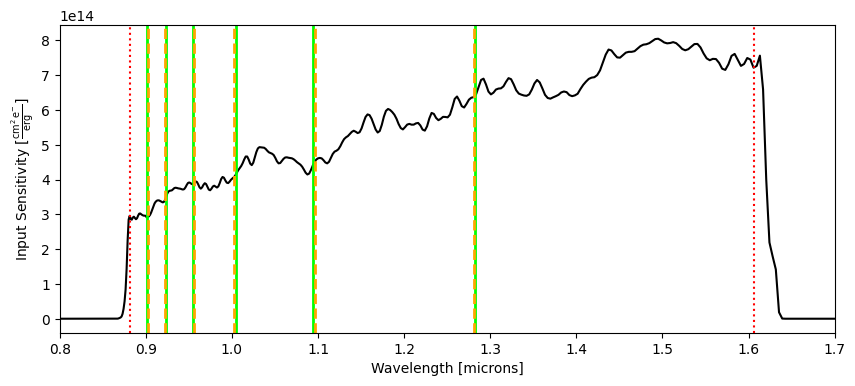

In [21]:
wav = nirda.reference.get_wavelength_position(np.linspace(-200, 400, 1000))
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(wav, nirda.reference.get_sensitivity(wav), c='k')
ax.axvline(np.polyval(l, le), c='r', ls=':')
ax.axvline(np.polyval(l, re), c='r', ls=':')
[ax.axvline(p, c='lime', lw=2) for p in paschen]
[ax.axvline(np.polyval(l, p), c='orange', lw=2, ls='--') for p in paschen_pix]
ax.set(xlim=(0.8, 1.7), xlabel='Wavelength [microns]', ylabel=f"Input Sensitivity [{nirda.reference.get_sensitivity(wav).unit.to_string('latex')}]");

In [22]:
# fig, ax = plt.subplots(figsize=(10, 4))
# ax.scatter(df.wavelength, df.y/df.norm, c=df.teff, s=0.1, cmap='coolwarm')
# ax.set(xlabel='Wavelength [microns]', ylabel='Signal [$e^-/pixel$]')

Now we can package this solution

In [23]:
r = {}
r['pix'] = np.arange(le - 10, re + 10, 0.25) * u.pixel
r['wav'] = np.polyval(l, r['pix'].value) * u.micron

In [24]:
from astropy.io import fits
from astropy.time import Time
import pandoraref as pr

In [ ]:
hdu0.header['CREATOR'] = ("Pandora DPC Software", "Software that created this file")
hdu0.header['AUTHOR'] = ("Christina Hedges", "Person or group that created this file")
hdu0.header['VERSION'] = ("Synthetic_V1", "")
hdu0.header['DATASRC'] = ("SIMULATION", "")
hdu0.header['DATE'] = Time.now().isot
hdu0.header["TELESCOP"] = ("NASA Pandora", "telescope")
hdu0.header["CAMERAID"] = ("H2rgCam", "ID of camera used in acquisition")
hdu0.header["INSTRMNT"] = ("NIRDA", "instrument")

In [27]:
def create_nirda_pixel_position(r, version):
    """Creates a wavelength normalization file."""

    hdr0 = fits.Header(
        [
            ("TELESCOP", "NASA Pandora", "telescope"),
            ("CAMERAID", "H2rgCam", "ID of camera used in acquisition"),
            ("INSTRMNT", "NIRDA", "instrument"),
            ("CREATOR", "Pandora DPC Software", "Software that created this file"),
            ('AUTHOR', "Christina Hedges", "Person or group that created this file"),
            ("VERSION", "Synthetic_V1", ""),
            ('DATASRC', "SIMULATION", ""),
            ("DATE", Time.now().isot, "creation date"),
        ]
    )

    hdr1 = fits.Header(
        [
            ("EXTNAME", "PIXEL POSITIONS", "name of extension"),
        ]
    )
    tab = fits.TableHDU.from_columns(
        [
            fits.Column(name="Pixel", format="E", array=r['pix'].value, unit=r['pix'].unit.to_string()),
            fits.Column(name="Wavelength", format="E", array=r['wav'].value, unit=r['wav'].unit.to_string()),
        ],
        header=hdr1,
    )

    hdulist = fits.HDUList([fits.PrimaryHDU(header=hdr0), tab])
    return hdulist

In [28]:
hdulist = create_nirda_pixel_position(r, 'dummy')
hdulist.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   ()      
  1  PIXEL POSITIONS    1 TableHDU        17   843R x 2C   ['E15.7', 'E15.7']   


In [29]:
hdulist.writeto("pandora_nir_pixel_positions.fits", overwrite=True)

You will need to save this and update `pandora-ref`.

This should look like what is currently in `pandora-ref`, however you should make sure the formats conform with the `pandora-ref` rules.

## Building the spectrum normalization 

Now we have to find the normalization function to make the units. To do this we will 

1. Apply our wavelength calibration
2. Estimate the SEDs of stars using phoenix models
3. Convolve the SEDs with a Gaussian to smooth signal and mimic PRF
4. Divide out the SEDs from each dataset
5. Fit the average normalization

In [30]:
from astropy.convolution import convolve, Gaussian1DKernel

In [31]:
sigma = 1.5
for tdx in tqdm(df.target.unique()):
    df1 = df[df.target == tdx]
    wav, sed = ps.phoenix.get_phoenix_model(df1.teff.values[0], jmag=df1.mag.values[0])
    k = (wav.to(u.micron).value > (df1.wavelength.min() - 0.1)) & (wav.to(u.micron).value < (df1.wavelength.max() + 0.1))
    wav, sed = wav[k], sed[k]
    pix = np.interp(wav.to(u.micron).value, np.polyval(wav_poly, np.linspace(-150, 150, 1000)), np.linspace(-150, 150, 1000))
    df.loc[df.target == tdx, 'sed'] = np.interp(df1.x.values, pix, convolve(sed.value, Gaussian1DKernel(int(sigma/np.median(np.diff(pix))))))

100%|███████████████████████████████████████████| 30/30 [00:11<00:00,  2.71it/s]


In [52]:
flux = df.y.values/(bin_frames * nirda.frame_time((400, 80))) * u.electron/u.pixel
expected_flux = df.sed.values * u.erg/(u.s * u.cm**2 * u.AA) 

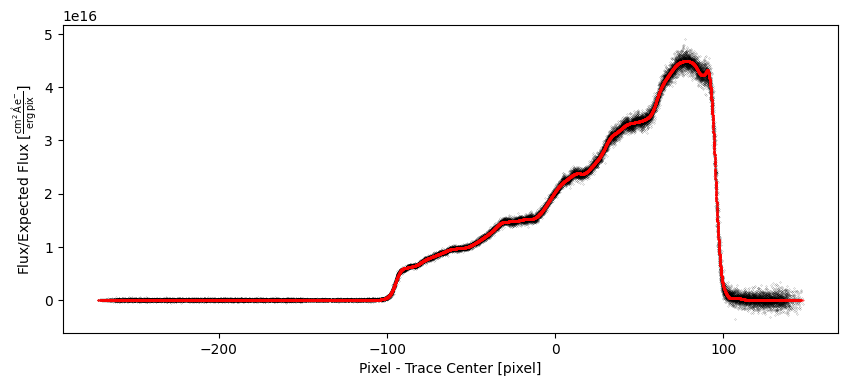

In [53]:
from lamatrix import Spline
s = Spline("x", knots=np.arange(-150, 150, 5))
s.fit(x=df.x.values, data=(flux/expected_flux).value)


fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(df.x.values, flux/expected_flux, s=0.01, c='k')
ax.set(xlabel='Pixel - Trace Center [pixel]', ylabel=f"Flux/Expected Flux [{(flux/expected_flux).unit.to_string('latex')}]")

ax.scatter(df.x.values, s.evaluate(x=df.x.values), c='r', s=0.1)
plt.show()

We've now created the per pixel spectrum normalization. This has units of

In [54]:
(flux/expected_flux).unit

Unit("cm2 Angstrom electron / (erg pix)")

In [55]:
sens_unit = (flux/expected_flux).unit

We can see how this normalizes our data and gives them the same units as the input SED

/Users/chedges/Library/Caches/pypoetry/virtualenvs/pandorapsf-Fwaspdv0-py3.9/lib/python3.9/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/chedges/Library/Caches/pypoetry/virtualenvs/pandorapsf-Fwaspdv0-py3.9/lib/python3.9/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


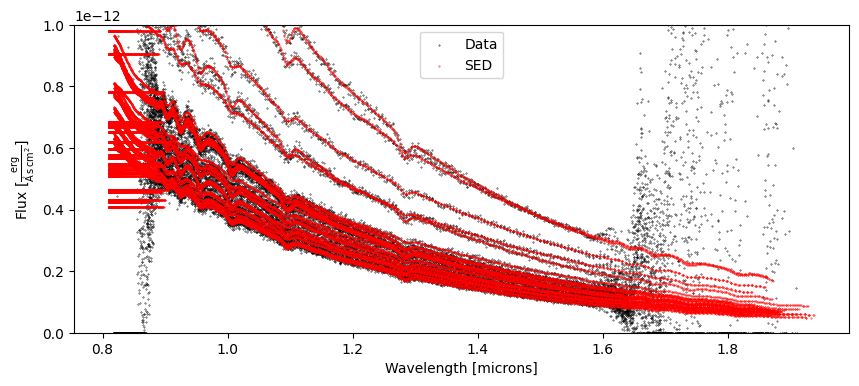

In [56]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(df.wavelength.values, flux/s.evaluate(x=df.x.values), s=0.1, c='k', label='Data')
ax.scatter(df.wavelength.values, df.sed.values, s=0.1, c='r', label='SED')
ax.set(ylim=(0, 1e-12), ylabel=f"Flux [{(u.erg/(u.s * u.cm**2 * u.AA)).to_string('latex')}]", xlabel='Wavelength [microns]')
ax.legend();

We also want the normalization per wavelength, which we calculate below.

In [57]:
w = np.polyval(l, np.arange(-150, 150, 1)) * u.micron
dw = np.gradient(w.value, np.arange(-150, 150, 1)) * u.micron/u.pixel

sens_per_wav = ((s.evaluate(x=np.arange(-150, 150, 1)) * (flux/expected_flux).unit) / dw).to(u.cm**2*u.electron/(u.erg))

This is the as measured sensitivity of Pandora

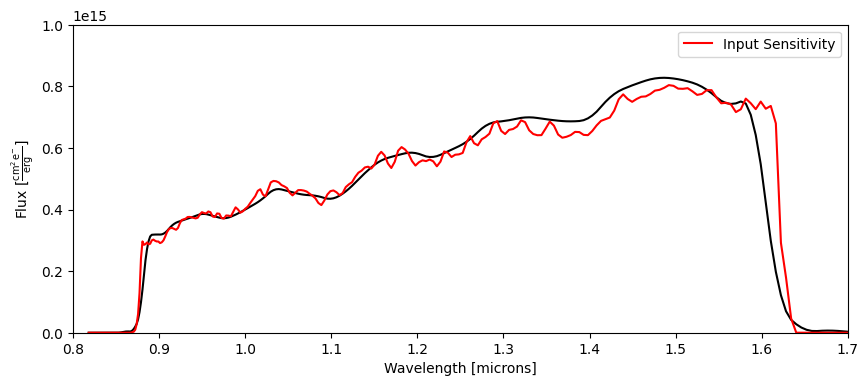

In [58]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(w, sens_per_wav, c='k')
ax.plot(w, nirda.sensitivity(w), c='r', label='Input Sensitivity')
ax.set(ylim=(0, 1e15), xlim=(0.8, 1.7), ylabel=f"Flux [{((u.cm**2 * u.electron)/(u.erg)).to_string('latex')}]", xlabel='Wavelength [microns]', label='As Measured Sensitivity')
ax.legend();

We see this has the correct magnitude and is fairly well aligned. The alignment will improve as more data is used to create this reference product and refine the wavelength to pixel solution. Note that the as measured sensitivity per wavelength is much smoother than the theoretical input because it has been convolved with the PRF.

In [59]:
df['sens_per_pix'] = s.evaluate(x=df.x.values)

We can show for any given target what the data we retrieve is compared to the input

/var/folders/bv/0t7fjlgx0mx3_3bdhxqzd7bmh_67k0/T/ipykernel_64252/4185064164.py:5: RuntimeWarning: invalid value encountered in sqrt
  ye = y**0.5


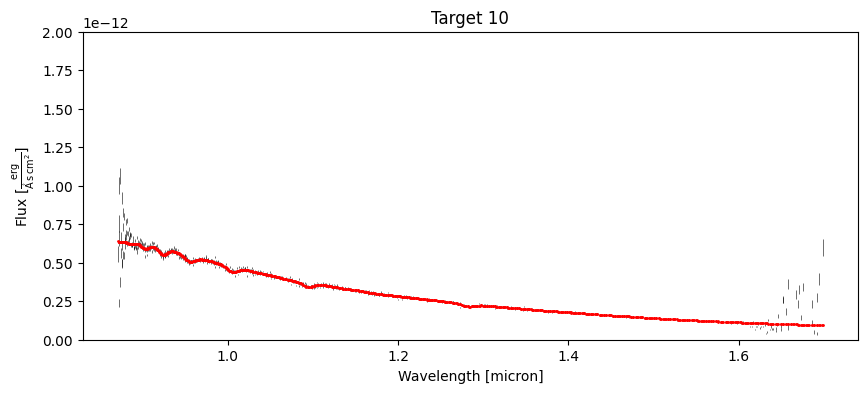

In [60]:
tdx = 10
k = df.target == tdx
k &= s.evaluate(x=df.x.values)/s.evaluate(x=np.asarray([0])) > 1e-2
y = (df[k].y.values/(bin_frames * nirda.frame_time((400, 80)))).value
ye = y**0.5
sens = s.evaluate(x=df[k].x.values)


fig, ax = plt.subplots(figsize=(10, 4))
ax.errorbar(df[k].wavelength.values, y/sens, ye/sens, ls='', c='k', lw=0.4)
ax.scatter(df[k].wavelength.values, df[k].sed.values, s=1, zorder=10, c='r')
ax.set(ylim=(0, 2e-12), xlabel='Wavelength [micron]', ylabel=f"Flux [{expected_flux.unit.to_string('latex')}]", title=f'Target {tdx}');

The sensitivity per wavelength should tell us what the zeropoint of Pandora is. 

To check this we can apply the sensitivity per wavelength to the SED, integrate over all wavelengths and show this is the same as the total electrons/second we measured with Pandora

In [61]:
sigma = 1.5
expected_flux, measured_flux = np.zeros((2, len(teffs)))
for tdx in tqdm(range(len(teffs))):
    wav, sed = ps.phoenix.get_phoenix_model(teffs[tdx], jmag=mags[tdx])
    k = (wav.to(u.micron).value > (df1.wavelength.min() - 0.1)) & (wav.to(u.micron).value < (df1.wavelength.max() + 0.1))
    wav, sed = wav[k], sed[k]
        
    expected_flux[tdx] = (np.trapz(sed * np.interp(wav.to(u.micron).value, w.value, sens_per_wav.value) * sens_per_wav.unit, wav)).to(u.electron/u.second).value
    fdx = 0
    j = (df.target == tdx) & (df.frame == fdx)
    measured_flux[tdx] = (np.trapz(df[j].y.values/(bin_frames * nirda.frame_time((400, 80))) * u.electron/u.pixel, df[j].x.values*u.pixel)).to(u.electron/u.second).value

100%|███████████████████████████████████████████| 30/30 [00:11<00:00,  2.69it/s]


[Text(0.5, 0, 'J Magnitude'), Text(0, 0.5, 'Total Flux [$e^-$]')]

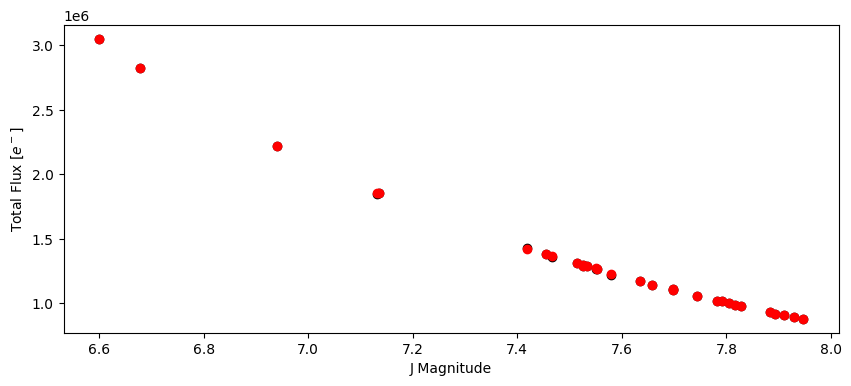

In [62]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(mags, measured_flux, c='k')
ax.scatter(mags, expected_flux, c='r')
ax.set(xlabel='J Magnitude', ylabel='Total Flux [$e^-$]')

This looks great, so we know this is working. 

Now we need to package this so we can include it in `pandora-ref`.

In [64]:
r = {}
r['pix'] = np.arange(le - 10, re + 10, 0.25) * u.pixel
r['wav'] = np.polyval(l, r['pix'].value) * u.micron
r['sens'] = s.evaluate(x=r['pix'].value) * sens_unit
r['center'] = (df.x0 - df.x).mean()
r['left_edge'] = le
r['right_edge'] = re

In [65]:
from astropy.io import fits
from astropy.time import Time
def create_nirda_spectrum_normalization(pix, wav, sens_per_pix, sens_per_wav, le, re, center, version):
    """Creates a wavelength normalization file."""

    hdr0 = fits.Header(
        [
            ("TELESCOP", "NASA Pandora", "telescope"),
            ("CAMERAID", "H2rgCam", "ID of camera used in acquisition"),
            ("INSTRMNT", "NIRDA", "instrument"),
            ("CREATOR", "Pandora DPC Software", "Software that created this file"),
            ('AUTHOR', "Christina Hedges", "Person or group that created this file"),
            ("VERSION", "Synthetic_V1", ""),
            ('DATASRC', "SIMULATION", ""),
            ("DATE", Time.now().isot, "creation date"),
        ]
    )

    hdr1 = fits.Header(
        [
            ("EXTNAME", "SOLUTION", "name of extension"),
            ("L_EDGE", le, "Left edge of the trace in pixel position"),
            ("R_EDGE", re, "Right edge of the trace in pixel position"),
            ("CENTER", center, "Center of the trace in pixel position"),
        ]
    )
    sens_per_wav[~np.isfinite(sens_per_wav.value)] = 0 * sens_per_wav.unit
    k = (sens_per_wav.value != 0) & np.isfinite(sens_per_wav.value)
    k = np.arange(np.max([0, np.where(k)[0][0] - 2]), np.min([len(k), np.where(k)[0][-1] + 3]), 1)
    tab = fits.TableHDU.from_columns(
        [
            fits.Column(name="Pixel", format="E", array=pix.value[k], unit=pix.unit.to_string()),
            fits.Column(name="Wavelength", format="E", array=wav.value[k], unit=wav.unit.to_string()),
            fits.Column(name="Sensitivity Per Pixel", format="E", array=sens_per_pix.value[k], unit=sens_per_pix.unit.to_string()),
            fits.Column(name="Sensitivity Per Wavelength", format="E", array=sens_per_wav.value[k], unit=sens_per_wav.unit.to_string()),
        ],
        header=hdr1,
    )

    hdulist = fits.HDUList([fits.PrimaryHDU(header=hdr0), tab])
    return hdulist

In [66]:
p = np.arange(le - 10, re + 10, 0.25)
w = np.polyval(l, p) * u.micron
dw = np.gradient(w.value, p) * u.micron/u.pixel

hdulist = create_nirda_spectrum_normalization(
    pix=p * u.pixel, 
    wav=np.polyval(l, p) * u.micron,
    sens_per_pix = s.evaluate(x=p) * u.Unit('cm2 Angstrom electron / (erg pix)'),
    sens_per_wav = ((s.evaluate(x=p) * u.Unit('cm2 Angstrom electron / (erg pix)')) / dw).to(u.cm**2*u.electron/(u.erg)),
    le=le,
    re=re,
    center=(df.x0 - df.x).mean(),
    version='dummy')
hdulist.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   ()      
  1  SOLUTION      1 TableHDU        28   843R x 4C   ['E15.7', 'E15.7', 'E15.7', 'E15.7']   


In [67]:
hdulist.writeto("pandora_nir_spectrum_normalization.fits", overwrite=True)

You now need to update `pandora-ref` with these solutions, following the rules for versioning. If you change anything about the format, you'll need to update `pandora-ref`.